# Code Demo

In [1]:
import os
import time
import pandas as pd
from PIL import Image
from Blackbox import *
from KLD import *
import cv2

# Set the path to this notebook file location
notebook_path = os.getcwd()

In [2]:
# Set variant to test, and which signature to present the variant
variant_name = "flat_unskel_128_kld"
presented_sig_source = "original"
presented_sig_pers = 38
presented_sig_num = 7

# Resize target obtained from variant_name
targ_size = int(variant_name[-7:-4])

In [3]:
# Load reference waveform library
ave_csv = notebook_path + f"/wfs/ave_wfs_{variant_name[:-4]}.csv"
ave_wfs = pd.read_csv(ave_csv, delimiter=",", header=None)

# Load and obtain normalisation min and max values
div_min_max = pd.read_csv("div_min_max_lib.csv", delimiter=",", header=0)
div_min, div_max = (div_min_max[div_min_max["variant"] == variant_name]["div_min"].values[0],
                    div_min_max[div_min_max["variant"] == variant_name]["div_max"].values[0])

# Load and obtain coefficient and intercept values for variant
coef_inter_df = pd.read_csv(notebook_path + f"/coefs_inters.csv", delimiter=",", index_col=0, header=0)
coef, inter = coef_inter_df.T[variant_name].T[0], coef_inter_df.T[variant_name].T[1]

In [4]:
# Obtain signature file path
if presented_sig_source == "original":
    folder = "full_org"
elif presented_sig_source == "forgeries":
    folder = "full_forg"
presented_sig = f"/signatures/{folder}/{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png"
presented_sig2 = f"/signatures/{folder}/{presented_sig_source}_{presented_sig_pers-10:02d}_{presented_sig_num+1:02d}.png"
presented_sig_path = notebook_path + presented_sig
presented_sig_path2 = notebook_path + presented_sig2

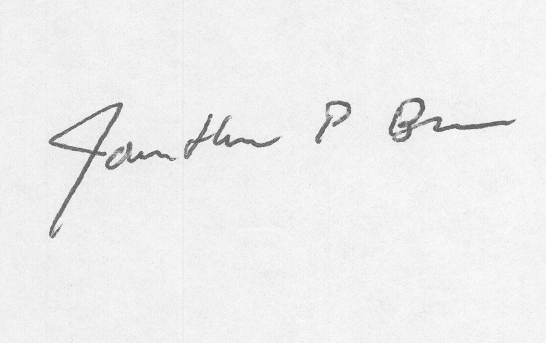

In [5]:
# The following cells are steps used in the black box section of the method
# Read image
im = read_img(presented_sig_path)
# im2 = read_img(presented_sig_path2)
display(Image.fromarray(np.uint8(im)))
# display(Image.fromarray(np.uint8(im2)))

In [6]:
# Deionise/clean image of noise
im = deionise_img(im)

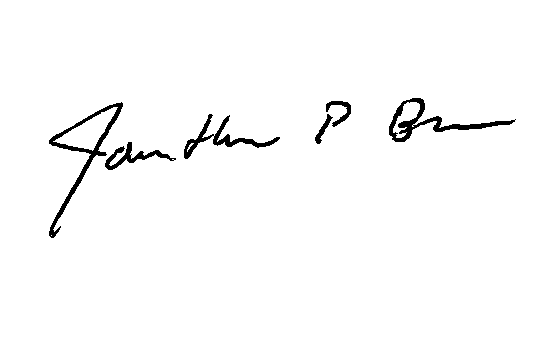

In [7]:
# Thresholded to black and white
im = to_bw_img(im)
Image.fromarray(np.uint8(im))

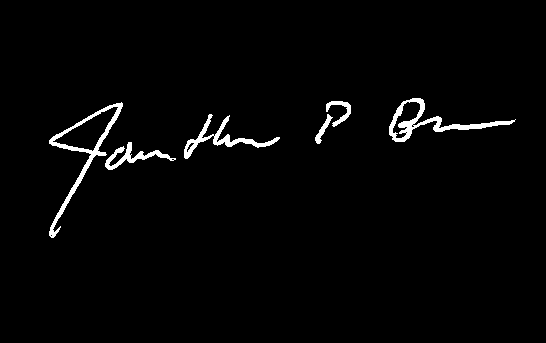

In [8]:
# Complement image and convert to binary
im = invert_img(im)
Image.fromarray(np.uint8(im*255))

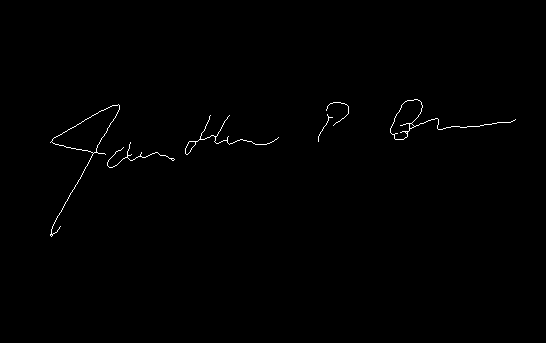

In [9]:
# Create skeletonised signature
skel_im = skeletonise_img(im)
Image.fromarray(np.uint8(skel_im*255))

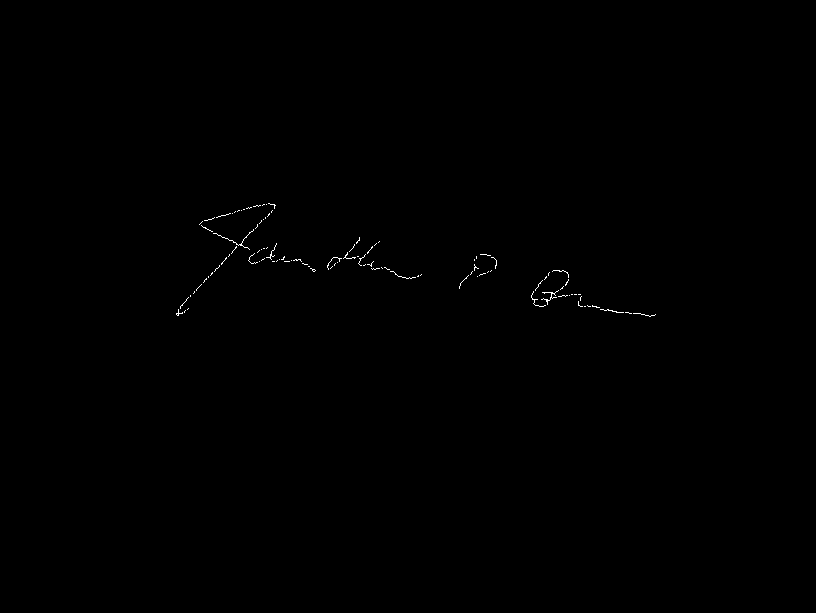

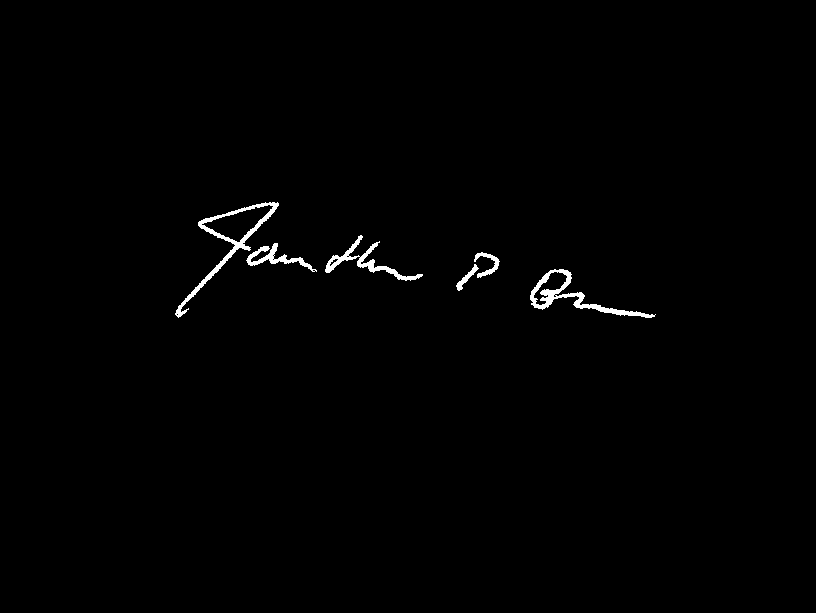

In [10]:
# Calculate the baseline slant and correct it
# Padding is added to ensure entire signature is retained in the result
# First variation happens here by bringing forward the skeletonised or un-skeletonised signature
skel_im_f = correct_baseline_slant_img(skel_im, skel_im) # bring forward skeletonised signature
unskel_im = correct_baseline_slant_img(im, skel_im) # bring forward un-skeletonised signature
display(Image.fromarray(np.uint8(skel_im_f*255)))
display(Image.fromarray(np.uint8(unskel_im*255)))

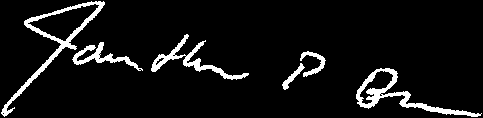

In [11]:
# Remove black space
im = crop_img(unskel_im)
Image.fromarray(np.uint8(im*255))

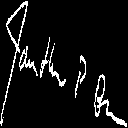

In [12]:
# Resize to target size
# Second variation happens here by using different resize sizes (512, 256, or 128)
target = (targ_size, targ_size)
im = resize_img(im, target)
Image.fromarray(np.uint8(im*255))

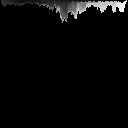

In [13]:
# Generate waveform of the signature
im = generate_waveform(im)
Image.fromarray(np.uint8(im*2))

In [14]:
# Extract the waveform information, storing it as a 1D array
# This is the last step of the black box section during classification
# Third variation happens here where the waveform information is extracted by tracking or flattening
presented_sig_wf_track = track_waveform(im)
presented_sig_wf_flat = flatten_waveform(im)
presented_sig_wf_track, presented_sig_wf_track.shape, presented_sig_wf_flat, presented_sig_wf_flat.shape

(array([ 0,  3,  5,  6,  7,  6,  5,  4,  4,  5,  5,  5,  4,  4,  5,  6,  5,
         4,  6,  6,  5,  6,  5,  5,  4,  2,  4,  3,  3,  3,  4,  4,  5,  3,
         4,  4,  4,  4,  5,  7,  6,  5,  5,  6,  6,  5,  7,  8,  7, 10,  9,
         9, 11,  9,  6,  8, 13, 12, 11, 13, 18, 20, 23, 21, 19, 21, 22, 18,
        13, 12, 12, 15, 14, 15, 18, 19, 19, 14, 11, 14, 14, 13, 12, 12, 11,
        11,  8,  7,  8,  7,  7,  5,  5,  6,  7,  7,  7, 10,  7,  8, 11, 13,
        12, 12, 10, 10,  8,  6,  5,  6,  5,  6, 11, 13, 12, 12,  7,  7,  8,
        11, 12,  0,  0,  0,  8,  4,  2,  0]),
 (128,),
 array([ 0, 25, 23, ...,  0,  0,  0], dtype=uint8),
 (16384,))

In [15]:
# With the reference waveform library loaded earlier, select the reference for the correct signee
# The library is created during training from all genuine signatures belonging to the signee
# The average of all genuine signatures is used as the reference
reference_wf = ave_wfs.iloc[presented_sig_pers-1]
reference_wf

0         0.000000
1        17.642857
2        23.571429
3        21.357143
4        19.071429
           ...    
16379     0.000000
16380     0.000000
16381     0.000000
16382     0.000000
16383     0.000000
Name: 37, Length: 16384, dtype: float64

In [16]:
# This is the first step of the dissimilarity section of the method
# Both waveforms are transformed into probability distributions
# A divergence measure is calculated between the distributions of the presented signature and the reference
# Fourth variation happens here where different divergence measures are used, either KLD or PSI
if "kld" in variant_name:
    sig_div = KLD(presented_sig_wf_flat, reference_wf)[0]
if "psi" in variant_name:
    sig_div = PSI(presented_sig_wf_flat, reference_wf)[0]
sig_div

0.5477396912482893

In [17]:
# Normalise the divergence measure according to the relevant min and max value for the variant
# This is the second and final step of the dissimilarity section of the method
sig_div_norm = norm_div(sig_div, div_min, div_max)
sig_div_norm, div_min, div_max

(0.011288246654933987, 0.3554470137980027, 17.39021630334371)

In [18]:
# Calculate the decision value (confidence value of class 1 - genuine, or class 0 - forgery)
# Using the relevant coefficient and intercept of the variant
decision_value = 1 / (1 + np.exp(-(inter + coef * sig_div_norm)))
decision_value, coef, inter

(0.9499043048584892, -65.93141823468527, 3.686676280055758)

In [19]:
# Based on the decision value, give an output
if decision_value > 0 :
    classification = "genuine"
elif decision_value < 0 :
    classification = "forged"
else :
    classification = "undecided"

print(f"{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png is a {classification} signature")

original_38_07.png is a genuine signature


In [20]:
%%time
# All together, and timing everything
# Load variant and signature details
variant_name = "flat_unskel_128_kld"
presented_sig_source = "original"
presented_sig_pers = 38
presented_sig_num = 7
targ_size = int(variant_name[-7:-4])

# Load libraries and relevant values
ave_csv = notebook_path + f"/wfs/ave_wfs_{variant_name[:-4]}.csv"
ave_wfs = pd.read_csv(ave_csv, delimiter=",", header=None)
div_min_max = pd.read_csv("div_min_max_lib.csv", delimiter=",", header=0)
div_min, div_max = (div_min_max[div_min_max["variant"] == variant_name]["div_min"].values[0],
                    div_min_max[div_min_max["variant"] == variant_name]["div_max"].values[0])
coef_inter_df = pd.read_csv(notebook_path + f"/coefs_inters.csv", delimiter=",", index_col=0, header=0)
coef, inter = coef_inter_df.T[variant_name].T[0], coef_inter_df.T[variant_name].T[1]

# Generate presented signature path
if presented_sig_source == "original":
    folder = "full_org"
elif presented_sig_source == "forgeries":
    folder = "full_forg"
presented_sig = f"/signatures/{folder}/{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png"
presented_sig_path = notebook_path + presented_sig

# Call the waveform information generation method
# Takes image file path as input and 1D array as output
if "track" in variant_name:
    if "_skel" in variant_name:
        presented_sig_wf = wf_blackbox_track_skel(presented_sig_path, targ_size)
    else:
        presented_sig_wf = wf_blackbox_track_unskel(presented_sig_path, targ_size)
else:
    if "_skel" in variant_name:
        presented_sig_wf = wf_blackbox_flat_skel(presented_sig_path, targ_size)
    else:
        presented_sig_wf = wf_blackbox_flat_unskel(presented_sig_path, targ_size)

# Obtain reference waveform information
reference_wf = ave_wfs.iloc[presented_sig_pers-1]

# Obtain divergence measure
if "kld" in variant_name:
    sig_div = KLD(presented_sig_wf, reference_wf)[0]
if "psi" in variant_name:
    sig_div = PSI(presented_sig_wf, reference_wf)[0]

# Normalise divergence measure
sig_div_norm = norm_div(sig_div, div_min, div_max)

# Calculate decision value
decision_value = 1 / (1 + np.exp(-(inter + coef * sig_div_norm)))

# Give output
if decision_value > 0 :
    classification = "genuine"
elif decision_value < 0 :
    classification = "forged"
else :
    classification = "undecided"

print(f"{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png is a {classification} signature")

original_38_07.png is a genuine signature
CPU times: total: 469 ms
Wall time: 472 ms


In [21]:
# Timing for each variant
time_dict = {}
variant_set = ["track_skel_512_kld", "track_skel_512_psi",
               "track_skel_256_kld", "track_skel_256_psi",
               "track_skel_128_kld", "track_skel_128_psi",
               "track_unskel_512_kld", "track_unskel_512_psi",
               "track_unskel_256_kld", "track_unskel_256_psi",
               "track_unskel_128_kld", "track_unskel_128_psi",
               "flat_skel_512_kld", "flat_skel_512_psi",
               "flat_skel_256_kld", "flat_skel_256_psi",
               "flat_skel_128_kld", "flat_skel_128_psi",
               "flat_unskel_512_kld", "flat_unskel_512_psi",
               "flat_unskel_256_kld", "flat_unskel_256_psi",
               "flat_unskel_128_kld", "flat_unskel_128_psi",]

for variant_name in variant_set:
    # Start timing
    start = time.time()
    
    # Load variant and signature details
    #variant_name = "flat_skel_256_kld"
    presented_sig_source = "original"
    presented_sig_pers = 38
    presented_sig_num = 7
    targ_size = int(variant_name[-7:-4])

    # Load libraries and relevant values
    ave_csv = notebook_path + f"/wfs/ave_wfs_{variant_name[:-4]}.csv"
    ave_wfs = pd.read_csv(ave_csv, delimiter=",", header=None)
    div_min_max = pd.read_csv("div_min_max_lib.csv", delimiter=",", header=0)
    div_min, div_max = (div_min_max[div_min_max["variant"] == variant_name]["div_min"].values[0],
                        div_min_max[div_min_max["variant"] == variant_name]["div_max"].values[0])
    coef_inter_df = pd.read_csv(notebook_path + f"/coefs_inters.csv", delimiter=",", index_col=0, header=0)
    coef, inter = coef_inter_df.T[variant_name].T[0], coef_inter_df.T[variant_name].T[1]

    # Generate presented signature path
    if presented_sig_source == "original":
        folder = "full_org"
    elif presented_sig_source == "forgeries":
        folder = "full_forg"
    presented_sig = f"/signatures/{folder}/{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png"
    presented_sig_path = notebook_path + presented_sig

    # Call the waveform information generation method
    # Takes image file path as input and 1D array as output
    if "track" in variant_name:
        if "_skel" in variant_name:
            presented_sig_wf = wf_blackbox_track_skel(presented_sig_path, targ_size)
        else:
            presented_sig_wf = wf_blackbox_track_unskel(presented_sig_path, targ_size)
    else:
        if "_skel" in variant_name:
            presented_sig_wf = wf_blackbox_flat_skel(presented_sig_path, targ_size)
        else:
            presented_sig_wf = wf_blackbox_flat_unskel(presented_sig_path, targ_size)

    # Obtain reference waveform information
    reference_wf = ave_wfs.iloc[presented_sig_pers-1]

    # Obtain divergence measure
    if "kld" in variant_name:
        sig_div = KLD(presented_sig_wf, reference_wf)[0]
    if "psi" in variant_name:
        sig_div = PSI(presented_sig_wf, reference_wf)[0]

    # Normalise divergence measure
    sig_div_norm = norm_div(sig_div, div_min, div_max)

    # Calculate decision value
    decision_value = 1 / (1 + np.exp(-(inter + coef * sig_div_norm)))

    # Give output
    if decision_value > 0 :
        classification = "genuine"
    elif decision_value < 0 :
        classification = "forged"
    else :
        classification = "undecided"

    print(f"{presented_sig_source}_{presented_sig_pers:02d}_{presented_sig_num:02d}.png is a {classification} signature")
    
    # Stop timing
    stop = time.time()
    
    # Print time taken
    print(f"Time taken for {variant_name}: {stop-start:.3f}s")
    print("")
    
    # Save the time taken in seconds
    time_dict[variant_name] = [stop-start]

time_df = pd.DataFrame(data=time_dict)

original_38_07.png is a genuine signature
Time taken for track_skel_512_kld: 0.309s

original_38_07.png is a genuine signature
Time taken for track_skel_512_psi: 0.302s

original_38_07.png is a genuine signature
Time taken for track_skel_256_kld: 0.113s

original_38_07.png is a genuine signature
Time taken for track_skel_256_psi: 0.107s

original_38_07.png is a genuine signature
Time taken for track_skel_128_kld: 0.079s

original_38_07.png is a genuine signature
Time taken for track_skel_128_psi: 0.060s

original_38_07.png is a genuine signature
Time taken for track_unskel_512_kld: 0.304s

original_38_07.png is a genuine signature
Time taken for track_unskel_512_psi: 0.294s

original_38_07.png is a genuine signature
Time taken for track_unskel_256_kld: 0.117s

original_38_07.png is a genuine signature
Time taken for track_unskel_256_psi: 0.111s

original_38_07.png is a genuine signature
Time taken for track_unskel_128_kld: 0.068s

original_38_07.png is a genuine signature
Time taken fo

In [22]:
# time_df = time_df.T
# time_df = time_df.rename(columns = {0:"time taken (s)"})
# time_df.to_csv(notebook_path + "/time_df.csv", index=True, header=True)

Time taken is around 500ms for the best performing variant (flat_skel_128_kld) which is a quarter of the stated 2s in Mondal and Kundu (2017).

Variants with the longest times are the flatten and 512 variants.
Divergence measure and Skeletonisation does not have much impact on the time taken.